In [9]:
#Se instala la librería graph-tool https://graph-tool.skewed.de/installation.html#debian-ubuntu

#Método para linux
# Escribir en la terminal
# apt-get install python3-graph-tool

#En linux el comando '!pip install networkx' puede fallar en diferentes instalaciones, es necesario crear un entorno virtual (lo cual es un proceso más tedioso)
# Una manera de instalar las librerías sin tantos pasos intermedios es escribir directamente en la terminal: 'sudo apt-get install python3-networkx'
# Más general sudo apt-get install python3-xyz' (donde xyz es el nombre de la librería que se desea instalar)

#Método para windows
# Es un proceso largo, se recomienda instalar una máquina virtual con linux y seguir el método anterior (pueden existir muchos errores al instalar graph-tool en windows)

In [12]:
import numpy          as np
import graph_tool.all as gt

from itertools import combinations

def generate_net_links(tmax = 100, lambda_ = 7.33, a = 0.09, b = -11.5, proba = 0.024):
    """
    Generate a corruption network based on our model.
    
    Parameters
    ---------

    tmax : int
           Number of iteration steps (default: 100).
    lambda_ : float
           Characteristic number of people per scandal (default: 7.33).
    a, b : float
           Parameters defining the number of repeated agents (nr) as a function
           of total number of agents (n): nr = a*n + b (default: 0.09, -11.5).
    proba : float
            Probability of selecting a repeated agent that was already involved in
            another scandal (default: 0.024).

    Returns
    -------
    links_list : list
                 A list of edge lists where each element correspond to
                 a particular iteration step.
    """
    
    t                          = 0
    links                      = []
    links_list                 = []
    agent_names                = set()
    last_agent_index           = 0
    repeated_agent_names       = set()
    total_repeated_agents      = 0
    
    while t < tmax:
        n_new_agents = int(np.round(np.random.exponential(lambda_)))
            
        if n_new_agents > 1:
        
            new_agent_names     = [x for x in np.arange(last_agent_index, last_agent_index + n_new_agents)]
            last_agent_index   += n_new_agents
            
            new_repeated_agents = int(np.round((a*(len(agent_names)) + b - total_repeated_agents)))
            
            if new_repeated_agents > 0:
                for i in range(min(new_repeated_agents, len(new_agent_names))):

                    if (np.random.uniform() <= proba) & (len(repeated_agent_names) > 0):
                        #select from repeated_agent_names
                        repeated_agent = np.random.choice(list(repeated_agent_names))
                    else:
                        #select from agent_names
                        repeated_agent = np.random.choice(list(repeated_agent_names^agent_names))
                        total_repeated_agents += 1

                    new_agent_names[i] = repeated_agent
                    repeated_agent_names.add(repeated_agent)
                    
            for agent_ in new_agent_names:
                agent_names.add(agent_)
            
            new_links = list(combinations(new_agent_names, 2))
            
            links_list += [new_links]
            t          += 1

    return links_list

edge_lists = generate_net_links(tmax = 100, a = 0.142) # e.g, [[(0, 1), (0, 3), ... (5, 6)], [(7, 8), (7, 9) ... (14, 15)], ... ]

def network(t, edges_list):
    g           = gt.Graph(directed = False)
    edge_list_t = np.concatenate(edges_list[:t])
    
    g.add_edge_list(edge_list_t, hashed = True)

    # Self loops and parallel edges are not allowed. 
    gt.remove_self_loops(g)
    gt.remove_parallel_edges(g)
    
    return g

final_network = network(100, edge_lists)
final_network

# Visualización de la red con graph-tool

# Calcular la disposición de los nodos
pos = gt.sfdp_layout(final_network)

# Dibujar la red
gt.graph_draw(final_network, pos, output_size=(1000, 1000), vertex_size=5, edge_pen_width=0.5, output="corruption_network.png")


<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7da280536510, at 0x7da2806aa840>

Número de nodos en la red: 487
Número de aristas en la red: 4285


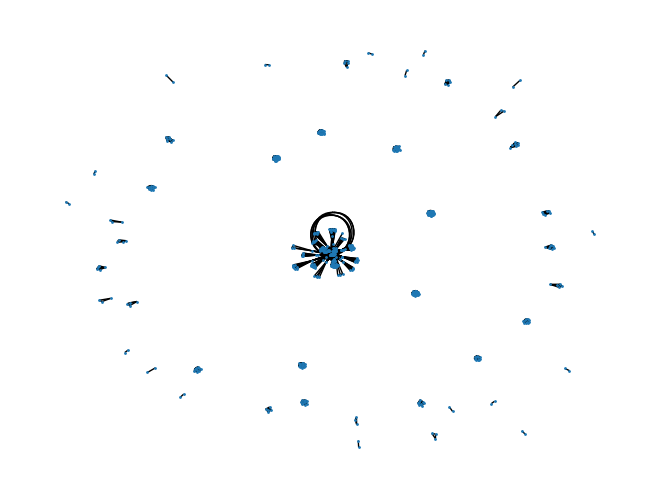

In [ ]:
#Modelo creado por mi, 1:00 a.m. 14 febrero 
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from pyvis.network import Network

def modeloRedCorruptaMartinsEtal(num_iterations, characteristic_size, recidivism_rate, beta, p):
    """
    Simula una red de corrupción usando el modelo propuesto por los investigadores.

    Parámetros:
    num_iterations (int): Número de iteraciones (escándalos) a simular.
    characteristic_size (int): Tamaño característico de los escándalos de corrupción.
    recidivism_rate (float): Tasa de reincidencia.
    beta (int): Controla el número mínimo de personas necesarias para la aparición de los primeros agentes reincidentes.
    p (float): Probabilidad de seleccionar nodos que ya eran reincidentes.

    Devuelve:
    nx.Graph: La red de corrupción simulada.
    """
    
    # Se definen las variables al inicio de la función
    total_nodes = 0
    reincidentes = []
    nodos_reincidentes = []
    nodos_no_reincidentes = []
    nodos_red = []
    nuevos_nodos_reincidentes = []
    nuevos_nodos_escandalo = []

    # Se crea una red vacía
    graph = nx.Graph()

    # Se simulan los escándalos
    
    for i in range(num_iterations):
        
        #Se añaden redes completas que representan escándalos políticos en cada iteración. El número de personas o el tamaño de estos gráficos completos se extrae al azar de una distribución exponencial (P) para imitar el comportamiento empírico (Fig. 1), es decir, P (S) ∼ e^( − S/SC)   , donde SC representa el tamaño característico (empíricamente ≈ 7 personas). 

        # Obtener el tamaño del escándalo de una distribución exponencial
        tamano_escandalo = max(2, int(random.expovariate(1.0 / characteristic_size))) # Se evita el tamaño 0

        # Crear un grafo completo con el tamaño del escándalo
        nuevo_grafo_escandalo = nx.complete_graph(tamano_escandalo)
        nuevos_nodos_escandalo = list(nuevo_grafo_escandalo.nodes())
        
        # Añadir la red completa a la red general
        graph = nx.disjoint_union(graph, nuevo_grafo_escandalo)
        nodos_red = list(graph.nodes())

        # Unir los nuevos nodos del escándalo con los nodos reincidentes de la anterior iteración
        # Se añaden aristas entre los nodos del escándalo y los nodos reincidentes de la iteración anterior
        for nodo in nuevos_nodos_escandalo:
            for nodo_reincidente_iteración_anterior in nuevos_nodos_reincidentes:
                graph.add_edge(nodo, nodo_reincidente_iteración_anterior) 

        # Se reinician los nodos reincidentes de la iteración anterior
        nuevos_nodos_reincidentes = [] 
        
        # Calcular el número de nodos reincidentes
        
        # Calcular el número total de nodos en la red
        total_nodes = graph.number_of_nodes()
        # Calcular el número de nodos reincidentes por medio de la formula dada en el artículo        
        r = max(0, int(recidivism_rate * total_nodes - beta))  # Se asegura que el número de reincidentes sea un entero positivo
        
        # Seleccionar nodos para convertirlos en reincidentes

        # Seleccionamos al azar nodos ya presentes en la red para convertirlos en reincidentes y hacer que pertenezcan al siguiente escándalo

        if r > 0:
            # Cuando es la primera ocasión que aparecen nodos reincidentes
            if len(nodos_reincidentes) == 0:
                # Seleccionar al azar nodos de la red
                reincidentes = random.sample(list(graph.nodes()), r)

                #Etiquetar nodos reincidentes
                for nodo in reincidentes:
                    graph.nodes[nodo]['reincidente'] = 1
            
                #Añadir los nodos etiquetados como reincidentes a una lista
                nodos_reincidentes = [nodo for nodo in graph if graph.nodes[nodo].get('reincidente', 0) == 1]
                
                #Añadir los nodos etiquetados como no reincidentes a una lista
                nodos_no_reincidentes = [nodo for nodo in graph if graph.nodes[nodo].get('reincidente', 0) == 0]

            #Cuando ya existen nodos reincidentes en la red
            else:
                #Seleccionar nodos que ya eran reincidentes con una pequeña probabilidad 'p' o nodos que se convertirán en reincidentes por primera vez con probabilidad '1−p' 

                #Se asignan probabilidades a los nodos reincidentes y no reincidentes
                probabilidades = [(1 - p)] * len(nodos_reincidentes) + [p] * len(nodos_no_reincidentes)
                probabilidades = np.array(probabilidades) / np.sum(probabilidades) 
                
                # Seleccionar nodos para convertirlos en reincidentes
                
                #Seleccionamos todos los nodos de la red
                #nodos_red_iteracion_pasada = list(set(nodos_red) - set(nuevos_nodos_escandalo))

                #Seleccionamos los nodos reincidentes con las probabilidades asignadas
                nodos_red = nodos_reincidentes + nodos_no_reincidentes

                nuevos_nodos_reincidentes = np.random.choice( 
                        nodos_red,
                        size= r,
                        replace=False,
                        p=probabilidades)
                
                #Se añaden a una lista temporal para unirlos a la red completa en la siguiente iteración
                nuevos_nodos_reincidentes = list(nuevos_nodos_reincidentes) # Convertir a lista normal

                #Etiquetarlos como reincidentes
                for nodo in nuevos_nodos_reincidentes:
                    graph.nodes[nodo]['reincidente'] = 1
                #Añadir los nodos etiquetados como reincidentes a la lista de nodos reincidentes
                nodos_reincidentes = [nodo for nodo in graph if graph.nodes[nodo].get('reincidente', 0) == 1]

    return graph

################################################################################

# Ejemplo de uso con el caso de Brasil

#Brazilian network comprises 404 nodes, 3549 edges, 14 connected components, and a giant component accounting for 77% of nodes and 93% of edges.

num_iterations = 65  # Número de escándalos en Brasil 
characteristic_size = 7 # Tamaño característico de los escándalos en Brasil
recidivism_rate = 0.065  # Tasa de reincidencia ajustada para el correcto funcionamiento del modelo (leer el artículo)
beta = 12 # Controla el número mínimo de personas necesarias para la aparición de los primeros agentes reincidentes
p = 0.025 # Probabilidad de seleccionar nodos que ya eran reincidentes

corruption_network_brazil = modeloRedCorruptaMartinsEtal(num_iterations, characteristic_size, recidivism_rate, beta, p)

print(f"Número de nodos en la red: {corruption_network_brazil.number_of_nodes()}")
print(f"Número de aristas en la red: {corruption_network_brazil.number_of_edges()}")

# Visualizar la red creada usando mathplotlib
import matplotlib.pyplot as plt
nx.draw(corruption_network_brazil, with_labels=False, node_size=1)
plt.show()

Número de nodos en la red: 467
Número de aristas en la red: 5101


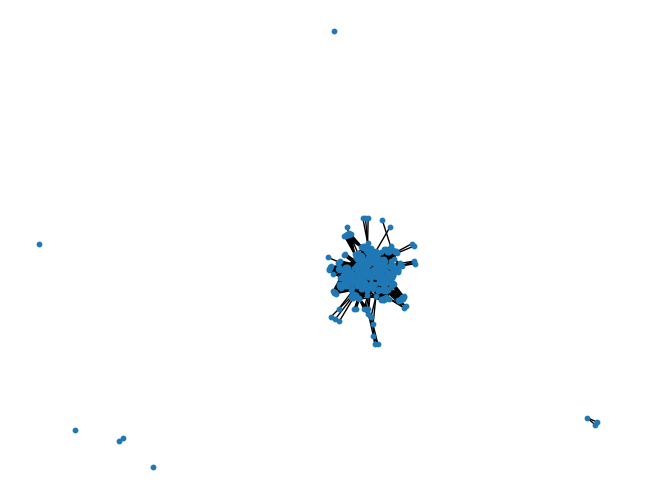

In [ ]:
# Modelo propuesto por Google NotebookLM
import numpy as np
import networkx as nx

def simulate_corruption_network(num_iterations, characteristic_size, recidivism_rate, beta, p):

    """

    Simula una red de corrupción usando el modelo propuesto.


    Parámetros:

    num_iterations (int): Número de iteraciones (escándalos) a simular.

    characteristic_size (float): Tamaño característico de los escándalos de corrupción.

    recidivism_rate (float): Tasa de reincidencia.

    beta (float): Controla el número mínimo de personas necesarias para la aparición de los primeros agentes reincidentes.

    p (float): Probabilidad de seleccionar nodos que ya eran reincidentes.


    Devuelve:

    nx.Graph: La red de corrupción simulada.

    """


    graph = nx.Graph()

    total_agents = 0

    recidivists = 0


    for i in range(num_iterations):

        # 1. Escoger el tamaño del escándalo de una distribución exponencial
        
        #Genera un numero (int) correspondiente al tamaño del escándalo
        scandal_size = int(np.random.exponential(characteristic_size)) + 1  # +1 para evitar tamaño 0

        new_agents = range(total_agents, total_agents + scandal_size)


        # 2. Añadir nuevos agentes al grafo

        graph.add_nodes_from(new_agents)


        # 3. Calcular el número de reincidentes

        r = int(recidivism_rate * total_agents - beta)

        r = max(0, min(r, scandal_size))  # Asegurar que el número de reincidentes sea válido


        # 4. Seleccionar agentes reincidentes

        if total_agents > 0 and r > 0:

            # Determinar cuántos reincidentes nuevos y viejos seleccionar

            num_old_recidivists = int(np.random.binomial(r, p))

            num_new_recidivists = r - num_old_recidivists


            old_recidivists = []

            if num_old_recidivists > 0:

                #Identificar los nodos que ya son reincidentes

                already_recidivists = [node for node, data in graph.nodes(data=True) if data.get('recidivist', False)]

                if already_recidivists:

                    old_recidivists = np.random.choice(already_recidivists, size=min(num_old_recidivists, len(already_recidivists)), replace=False)


            new_recidivists = []

            if num_new_recidivists > 0:

                # Asegurarse de no seleccionar los mismos nodos que old_recidivists

                eligible_nodes = [node for node in graph.nodes() if node not in old_recidivists and node < total_agents]

                if eligible_nodes:

                    new_recidivists = np.random.choice(eligible_nodes, size=min(num_new_recidivists, len(eligible_nodes)), replace=False)


            recidivist_agents = np.concatenate((old_recidivists, new_recidivists))


            # Marcar los nuevos reincidentes como tales

            for agent in new_recidivists:

                graph.nodes[agent]['recidivist'] = True


            # 5. Crear conexiones entre todos los agentes en el escándalo (gráfico completo)

            all_agents = np.concatenate((new_agents, recidivist_agents)).astype(int)

            for agent1 in all_agents:

                for agent2 in all_agents:

                    if agent1 != agent2:

                        graph.add_edge(agent1, agent2)

        else:

            #Si no hay reincidentes, crear conexiones entre los nuevos agentes

            for agent1 in new_agents:

                for agent2 in new_agents:

                    if agent1 != agent2:

                        graph.add_edge(agent1, agent2)


        total_agents += scandal_size

        recidivists += r


    return graph


# Ejemplo de uso

num_iterations = 65  # Número de escándalos en España

characteristic_size = 7

recidivism_rate = 0.065  # Tasa de reincidencia en España

beta = 12

p = 0.025


corruption_network = simulate_corruption_network(num_iterations, characteristic_size, recidivism_rate, beta, p)


print(f"Número de nodos en la red: {corruption_network.number_of_nodes()}")

print(f"Número de aristas en la red: {corruption_network.number_of_edges()}")

# Visualizar la red creada usando mathplotlib
import matplotlib.pyplot as plt
nx.draw(corruption_network, with_labels=False, node_size=10)
plt.show()

In [ ]:
#Modelo de red corrupta de Martins et al. (versión "mejorada")

import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from pyvis.network import Network

def modeloRedCorruptaMartinsEtal_mejorado(num_iterations, characteristic_size, recidivism_rate, beta, p):
    """
    Simula una red de corrupción usando el modelo propuesto por los investigadores (versión mejorada).
    """

    graph = nx.Graph()
    total_nodes = 0
    nodos_reincidentes_pendientes = [] # Lista para almacenar nodos reincidentes de la iteración anterior

    for _ in range(num_iterations): 

        # 1. Escoger el tamaño del escándalo
        scandal_size = max(2, int(random.expovariate(1.0 / characteristic_size)))

        # 2. Crear grafo completo del escándalo
        scandal_graph = nx.complete_graph(scandal_size)
        scandal_nodes = list(scandal_graph.nodes())

         # Añadir el grafo completo a la red 
        graph = nx.disjoint_union(graph, scandal_graph)
    
        # Calcular el número total de nodos en la red
        total_nodes = graph.number_of_nodes()
    
        # 2. Calcular el número de nodos reincidentes
        r = max(0, int(recidivism_rate * total_nodes - beta))  # Se asegura que el número de reincidentes sea un entero positivo
        
        # 2.1 Seleccionar nodos reincidentes
        # Se seleccionarán nodos al azar dentro de la red, mediante una probabilidad 'p' para los nodos reincidentes y '1-p' para los no reincidentes
        # Los nodos reicidentes seleccionados se conectarán al nuevo escándalo en la siguiente iteración

        if r > 0:
            # Identificar nodos reincidentes y no reincidentes
            recidivists = [node for node, data in graph.nodes(data=True) if data.get('recidivist', False)]
            non_recidivists = [node for node in graph.nodes() if node not in recidivists and node not in scandal_nodes ] # Excluimos nodos del nuevo escándalo

            nodos_disponibles_reincidencia = non_recidivists + recidivists

            if nodos_disponibles_reincidencia > 0: # Asegurarse de que haya nodos disponibles para reincidir
                probabilities = [(1 - p)] * len(non_recidivists) + [p] * len(recidivists)
                probabilities = np.array(probabilities) / np.sum(probabilities) # Normalizar probabilidades

                
                new_recidivists_iteracion_actual = np.random.choice(
                    nodos_disponibles_reincidencia,
                    size=min(r, len(nodos_disponibles_reincidencia)), # No seleccionar más reincidentes de los disponibles
                    replace=False,
                    p=probabilities[:len(nodos_disponibles_reincidencia)] # Ajustar probabilidades al tamaño correcto
                    )

                # Marcar como reincidentes y guardar para conectar en la *próxima* iteración
                for node in new_recidivists_iteracion_actual:
                    graph.nodes[node]['recidivist'] = True
                    nodos_reincidentes_pendientes.append(node)


        # 2.2 Conectar reincidentes *pendientes* al *nuevo* escándalo (de *esta* iteración)
        for nodo_reincidente in nodos_reincidentes_pendientes:
            nodo_nuevo_escandalo = random.choice(nuevos_nodos_escandalo) if nuevos_nodos_escandalo else None # Elegir nodo del nuevo escándalo
            if nodo_nuevo_escandalo: # Asegurarse de que haya nodos en el nuevo escándalo
                graph.add_edge(nodo_reincidente, nodo_nuevo_escandalo)
        nodos_reincidentes_pendientes = [] # Limpiar la lista para la siguiente iteración

    return graph

In [9]:
import networkx as nx
import random
import math

def generar_tamano_escandalo(tamano_caracteristico):
    """Genera un tamaño de escándalo aleatorio usando distribución exponencial."""
    return max(2, int(random.expovariate(1.0 / tamano_caracteristico))) # Asegura tamaño mínimo 1

def agregar_escandalo(grafo, iteracion, tamano_caracteristico, tasa_reincidencia, beta, prob_reincidente_reincidente):
    """Agrega un nuevo escándalo al grafo."""

    tamano_escandalo = generar_tamano_escandalo(tamano_caracteristico)
    nuevos_nodos = list(range(grafo.number_of_nodes(), grafo.number_of_nodes() + tamano_escandalo))

    grafo.add_nodes_from(nuevos_nodos)
    grafo.add_edges_from([(u, v) for i, u in enumerate(nuevos_nodos) for j, v in enumerate(nuevos_nodos) if i < j]) # Grafo completo

    num_nodos_actuales = grafo.number_of_nodes()
    num_reincidentes_esperados = max(0, int(tasa_reincidencia * num_nodos_actuales - beta)) # Asegura no reincidentes negativos

    reincidentes_agregados = 0
    nodos_existentes = list(grafo.nodes())[:-tamano_escandalo] # Nodos existentes antes del nuevo escandalo


    if nodos_existentes and num_reincidentes_esperados > 0: # Solo si hay nodos existentes y se esperan reincidentes

        nodos_reincidentes_indices = random.sample(range(len(nodos_existentes)), min(num_reincidentes_esperados, len(nodos_existentes)))
        nodos_reincidentes = [nodos_existentes[i] for i in nodos_reincidentes_indices]

        for nodo_reincidente in nodos_reincidentes:
            if random.random() < prob_reincidente_reincidente:
                # Reincidente ya era reincidente (probabilidad p) - No hacemos nada especial aquí en este modelo simple
                pass # En un modelo más complejo, podríamos rastrear reincidencia múltiple
            else:
                # Reincidente nuevo (probabilidad 1-p) - Conectamos con el nuevo escandalo
                nodo_nuevo_escandalo = random.choice(nuevos_nodos) # Conectar a un nodo aleatorio del nuevo escandalo
                grafo.add_edge(nodo_reincidente, nodo_nuevo_escandalo)
            reincidentes_agregados += 1


    return grafo


def simular_red_corrupcion(num_escandalos, tamano_caracteristico, tasa_reincidencia, beta, prob_reincidente_reincidente):
    """Simula la red de corrupción durante un número dado de escándalos."""
    grafo = nx.Graph()
    for iteracion in range(num_escandalos):
        grafo = agregar_escandalo(grafo, iteracion, tamano_caracteristico, tasa_reincidencia, beta, prob_reincidente_reincidente)
    return grafo


Red de corrupción simulada corregida con 467 nodos y 3601 aristas.
Coeficiente de clustering promedio (corregida): 0.7092


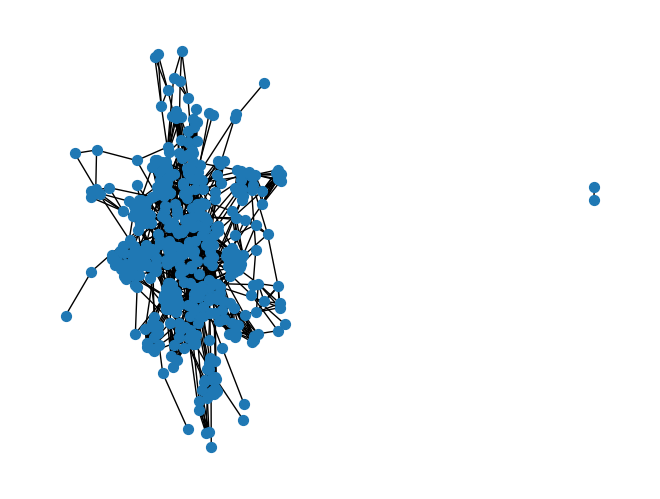

In [3]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from pyvis.network import Network

def modeloRedCorruptaMartinsEtal_corregido(num_iterations, characteristic_size, recidivism_rate, beta, p):
    """
    Simula una red de corrupción usando el modelo propuesto por los investigadores (versión corregida y simplificada).
    """

    graph = nx.Graph()
    total_nodes = 0
    recidivists = [] # Lista para *todos* los reincidentes a lo largo de la simulación
    nodos_reincidentes_pendientes = [] # Lista para reincidentes *de la iteración anterior*

    for _ in range(num_iterations):

        # 1. Tamaño del escándalo
        scandal_size = max(2, int(random.expovariate(1.0 / characteristic_size)))

        # 2. Crear grafo completo del escándalo
        scandal_graph = nx.complete_graph(scandal_size)
        scandal_nodes_local = list(scandal_graph.nodes()) # Índices locales (0, 1, 2, ...)
        num_nodos_previos = graph.number_of_nodes()
        nuevos_nodos_escandalo = [n + num_nodos_previos for n in scandal_nodes_local] # Índices globales en el grafo principal

        # 3. Añadir nodos y aristas del escándalo *directamente* al grafo principal (¡sin disjoint_union!)
        graph.add_nodes_from(nuevos_nodos_escandalo)
        graph.add_edges_from([(u + num_nodos_previos, v + num_nodos_previos) for u, v in scandal_graph.edges()])

        total_nodes = graph.number_of_nodes()

        # 4. Calcular número de reincidentes
        r = max(0, int(recidivism_rate * total_nodes - beta))

        # 5. Seleccionar nodos reincidentes para *esta* iteración
        new_recidivists_iteracion_actual = [] # Lista para los reincidentes *de esta iteración*
        if r > 0:
            non_recidivists_disponibles = [node for node in graph.nodes() if node not in recidivists and node not in nuevos_nodos_escandalo]
            recidivists_disponibles = [node for node in recidivists if node not in nuevos_nodos_escandalo] # Reincidentes *anteriores* disponibles

            nodos_disponibles_reincidencia = non_recidivists_disponibles + recidivists_disponibles

            if nodos_disponibles_reincidencia:
                probabilities = [(1 - p)] * len(non_recidivists_disponibles) + [p] * len(recidivists_disponibles)
                probabilities = np.array(probabilities) / np.sum(probabilities) if np.sum(probabilities) > 0 else None

                if probabilities is not None:
                    new_recidivists_iteracion_actual_np = np.random.choice(
                        nodos_disponibles_reincidencia,
                        size=min(r, len(nodos_disponibles_reincidencia)),
                        replace=False,
                        p=probabilities[:len(nodos_disponibles_reincidencia)]
                    )
                    new_recidivists_iteracion_actual = list(new_recidivists_iteracion_actual_np) # Convertir a lista normal

                    # Marcar como reincidentes *en el grafo principal* y añadir a la lista *global* de reincidentes
                    for node in new_recidivists_iteracion_actual:
                        graph.nodes[node]['recidivist'] = True
                        recidivists.append(node) # ¡Acumular a la lista *global*!
                        nodos_reincidentes_pendientes.append(node) # Guardar para conectar en la *próxima* iteración


        # 6. Conectar reincidentes *pendientes* (de la iteración *anterior*) al *nuevo* escándalo (de *esta* iteración)
        for nodo_reincidente in nodos_reincidentes_pendientes: # Reincidentes *pendientes* de *iteraciones anteriores*
            nodo_nuevo_escandalo = random.choice(nuevos_nodos_escandalo) if nuevos_nodos_escandalo else None
            if nodo_nuevo_escandalo:
                graph.add_edge(nodo_reincidente, nodo_nuevo_escandalo) # ¡Añadir arista al *grafo principal*!
        nodos_reincidentes_pendientes = [] # Limpiar lista para la *siguiente* iteración


    return graph


# -- Parámetros de simulación --
num_iterations_sim = 65
characteristic_size_sim = 7
recidivism_rate_sim = 0.065
beta_sim = 12
p_sim = 0.025

# -- Ejecutar simulación corregida --
red_simulada_corregida = modeloRedCorruptaMartinsEtal_corregido(num_iterations_sim, characteristic_size_sim, recidivism_rate_sim, beta_sim, p_sim)

print(f"Red de corrupción simulada corregida con {red_simulada_corregida.number_of_nodes()} nodos y {red_simulada_corregida.number_of_edges()} aristas.")
clustering_coef_corregida = nx.average_clustering(red_simulada_corregida)
print(f"Coeficiente de clustering promedio (corregida): {clustering_coef_corregida:.4f}")

# -- Visualización (opcional) --
import matplotlib.pyplot as plt
nx.draw(red_simulada_corregida, node_size=50)
plt.show()

Red de corrupción simulada con 439 nodos y 3400 aristas.


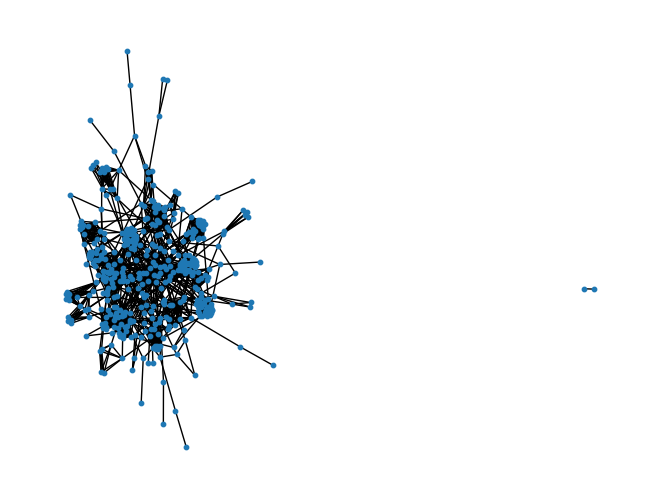

In [ ]:
# -- Parámetros de la simulación --
num_escandalos_simulacion = 65 # Similar al dataset brasileño
tamano_caracteristico_escandalos = 7
tasa_reincidencia_simulacion = 0.065 # Similar a la tasa española
beta_simulacion = 12
prob_reincidente_reincidente_simulacion = 0.025

# -- Ejecutar la simulación --
red_simulada = simular_red_corrupcion(num_escandalos_simulacion, tamano_caracteristico_escandalos, tasa_reincidencia_simulacion, beta_simulacion, prob_reincidente_reincidente_simulacion)

print(f"Red de corrupción simulada con {red_simulada.number_of_nodes()} nodos y {red_simulada.number_of_edges()} aristas.")

# Puedes visualizar la red (requiere matplotlib):
import matplotlib.pyplot as plt
nx.draw(red_simulada, node_size=10)
plt.show()

In [7]:
#Se crea la función que calcula todas las métricas de la red

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scienceplots
from networkx.algorithms import community

#Funcion para graficar la red

def mostrarRed(G,nombre):
    
    plt.style.use('science')

    plt.figure(figsize=(4, 4))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, node_color='#9FA3D5', edge_color='#3B4285', with_labels=False)
    plt.title(f'Red: {nombre}')
    plt.savefig(f'red_{nombre}.png', dpi=300)
    plt.show()

#Funcion para graficar la distribución de grados

def distribucionDeGrado(G, nombre):
    # Obtener los grados de los nodos y calcular la distribución de frecuencia
    degrees = list(dict(nx.degree(G)).values())
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    probs = counts / len(G)

    # Eliminar grados con frecuencia cero
    non_zero_probs = probs[probs > 0]
    non_zero_degrees = unique_degrees[probs > 0]

    # Tomar el logaritmo de las probabilidades y los grados
    log_probs = np.log(non_zero_probs)
    log_degrees = np.log(non_zero_degrees)

    # Realizar un ajuste lineal
    slope, intercept, r_value, p_value, std_err = linregress(log_degrees, log_probs)

    # Calcular el exponente de la ley de potencias
    gamma = round(slope,2)
    
    # Crear el gráfico

    plt.style.use('science')

    # Graficar con escala logarítmica únicamente en el eje y (Distribución de grados en una red)
    plt.figure(figsize=(4, 4))

    plt.plot(non_zero_degrees, non_zero_probs, 'o-', color='#3B4285')
    plt.yscale('log')
    plt.xlabel('Grado')
    plt.ylabel('Probabilidad')
    plt.title('Distribución de grados')
    plt.legend()

    plt.savefig(f'distribucion_de_grados_{nombre}.png', dpi=300)
    plt.show()
    
    plt.figure(figsize=(4, 4)) 

    plt.loglog(unique_degrees, probs, 'o', color='#9FA3D5')
    plt.plot(unique_degrees, np.exp(intercept + slope * np.log(unique_degrees)), '--', label='Ajuste lineal', color='#3B4285')

    plt.xlabel('Grado (log)')
    plt.ylabel('Probabilidad (log)')
    plt.legend()
    plt.title('Distribución de grados (escala logarítmica)')

    # Guardar el gráfico con mayor resolución
    plt.savefig(f'distribucion_de_grados_log_{nombre}.png', dpi=300)
    plt.show()
    
    # Imprimir el exponente
    print("Exponente de la ley de potencias (gamma):", gamma)    

#Función para calcular la estructura en comunidades

def estructuraComunidades(G, nombre):
    # Detectar comunidades usando el algoritmo de detección de comunidades de Louvain
    comunidades = community.louvain_communities(G)

    # Número de comunidades
    num_comunidades = len(comunidades)
    
    #Cantidad de nodos en cada comunidad
    nodos_comunidad = [len(comunidad) for comunidad in comunidades]
    
    # Promedio de nodos por comunidad
    promedio_nodos = round(np.mean(nodos_comunidad),2)

    # Crear un diccionario de colores para las comunidades
    color_map = {}
    for i, comunidad in enumerate(comunidades):
        for node in comunidad:
            color_map[node] = i
            
    # Crear el gráfico de la red con colores para las comunidades
    plt.figure(figsize=(4, 4)) # Tamaño del gráfico
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, node_color=list(color_map.values()), edge_color='gray', with_labels=False, cmap=plt.cm.tab20)
    plt.title(f'Red: {nombre} (Comunidades)')
    plt.savefig(f'comunidades_{nombre}.png', dpi=300)
    plt.show()
    
    # Imprimir el número de comunidades y el tamaño de cada una
    print(f"Número de comunidades: {num_comunidades}")
    print(f"Número de nodos por comunidad: {nodos_comunidad}")
    print(f"Promedio de nodos por comunidad: {promedio_nodos}")

    # Encontrar la comunidad más grande
    max_comunidad = max(nodos_comunidad)

    print(f"Comunidad más grande: {max_comunidad} nodos")
    
    #Etiquetar los nodos de la comunidad más grande
    nodos_max_comunidad = [node for node in G.nodes() if node in comunidades[np.argmax(nodos_comunidad)]]
    
    #Seleccionar la red de la comunidad más grande
    G_max_comunidad = G.subgraph(nodos_max_comunidad)
    return G_max_comunidad

         
# Propiedad de mundo pequeño

def mundoPequeno(G, G_max_comunidad, nombre):
    
    # Calcular el coeficiente de agrupamiento global
    clustering_coeff = round(nx.average_clustering(G),2)

    # Calcular el coeficiente de agrupamiento local (comunidad más grande)
    clustering_coeff_local = round(nx.average_clustering(G_max_comunidad),2)
    
    # Calcular el camino medio más corto de la red local
    try:
        average_path_length = round(nx.average_shortest_path_length(G_max_comunidad),2)
    except nx.NetworkXError:
        average_path_length = round(float('inf'),2)

    print(f"Coeficiente de agrupamiento global: {clustering_coeff}")
    print(f"Coeficiente de agrupamiento local: {clustering_coeff_local}")
    print(f"Camino medio más corto: {average_path_length}")
    
    if  (clustering_coeff_local > .90 and average_path_length < 5):
        print(f"La red '{nombre}' tiene la propiedad de mundo pequeño.")
    else:
        print(f"La red '{nombre}' no tiene la propiedad de mundo pequeño.")
    
#Asortaividad

def asortatividad(G, G_max_comunidad):
    # Calcular el coeficiente de asortatividad de grado global
    assortativity_coeff = round(nx.degree_assortativity_coefficient(G),2)
    # Calcular el coeficiente de asortatividad de grado local
    assortativity_coeff_local = round(nx.degree_assortativity_coefficient(G_max_comunidad),2)
    # Imprimir los coeficientes de asortatividad
    print(f"Coeficiente de Asortatividad Global: {assortativity_coeff}")
    print(f"Coeficiente de Asortatividad Local: {assortativity_coeff_local}")
 
def densidad(G, G_max_comunidad):
    # Calcular la densidad de la red global
    density = round(nx.density(G), 2)
    # Calcular la densidad de la red local
    density_local = round(nx.density(G_max_comunidad), 2)
    # Imprimir la densidad
    print(f"Densidad de la red global: {density}")
    print(f"Densidad de la red: {density_local}")
    
#Función global que calcula todas las métricas
            
def metricasRed(G, nombre):
    # Mostrar la red
    mostrarRed(G, nombre)
    # Obtener los grados de los nodos y calcular la distribución de frecuencia
    distribucionDeGrado(G, nombre)
    # Estructura en comunidades
    G_max_comunidad = estructuraComunidades(G, nombre)
    # Propiedad de mundo pequeño
    mundoPequeno(G, G_max_comunidad, nombre)
    # Asortatividad
    asortatividad(G, G_max_comunidad)
    # Densidad
    densidad(G, G_max_comunidad)

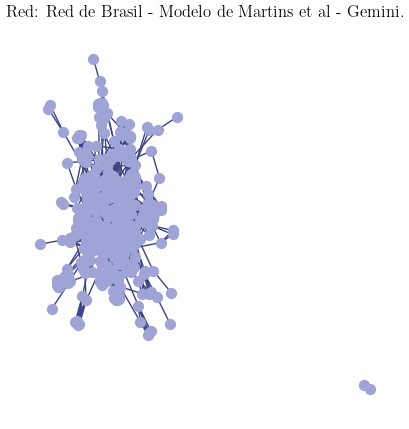

C:\Users\Tierra\AppData\Local\Temp\ipykernel_34940\1016749115.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


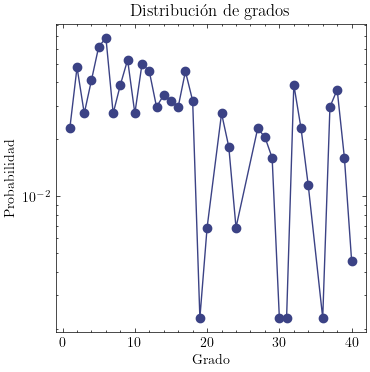

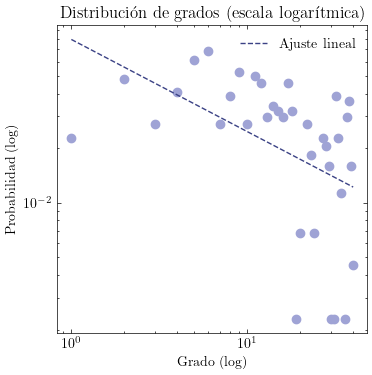

Exponente de la ley de potencias (gamma): -0.51


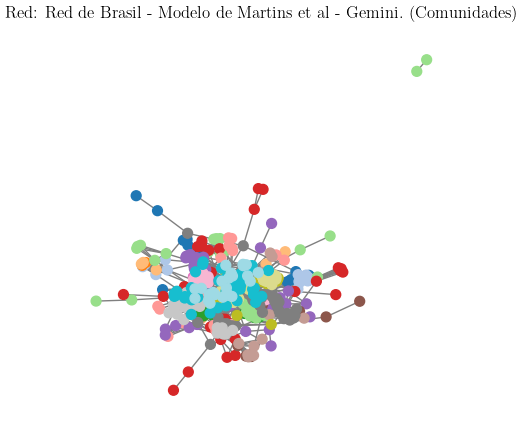

Número de comunidades: 19
Número de nodos por comunidad: [24, 14, 2, 15, 24, 34, 32, 21, 30, 8, 18, 18, 15, 38, 29, 20, 27, 46, 24]
Promedio de nodos por comunidad: 23.11
Comunidad más grande: 46 nodos
Coeficiente de agrupamiento global: 0.71
Coeficiente de agrupamiento local: 0.67
Camino medio más corto: 3.52
La red 'Red de Brasil - Modelo de Martins et al - Gemini.' no tiene la propiedad de mundo pequeño.
Coeficiente de Asortatividad Global: 0.91
Coeficiente de Asortatividad Local: 0.81
Densidad de la red global: 0.04
Densidad de la red: 0.13


In [11]:
#Calcular las métricas de la red de corrupción de Brasil
nombre = 'Red de Brasil - Modelo de Martins et al - Gemini.'
metricasRed(red_simulada, nombre)

Número de nodos en la red: 305
Número de aristas en la red: 2510


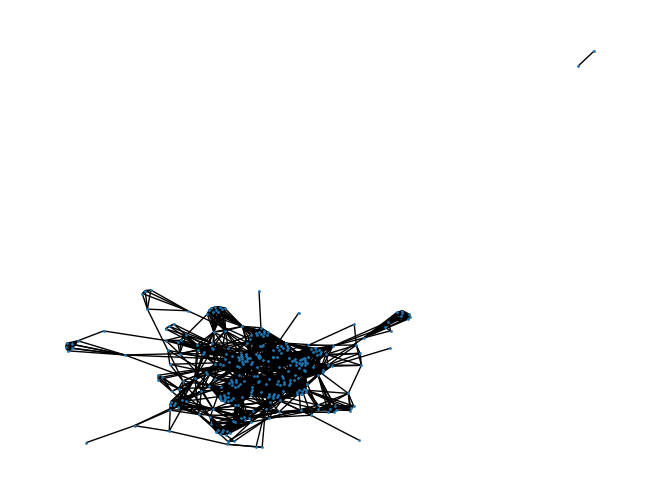

In [2]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from pyvis.network import Network

def modeloRedCorruptaMartinsEtal(num_iterations, characteristic_size, recidivism_rate, beta, p):
    """
    Simula una red de corrupción usando el modelo propuesto por los investigadores.

    Parámetros:
    num_iterations (int): Número de iteraciones (escándalos) a simular.
    characteristic_size (int): Tamaño característico de los escándalos de corrupción.
    recidivism_rate (float): Tasa de reincidencia.
    beta (int): Controla el número mínimo de personas necesarias para la aparición de los primeros agentes reincidentes.
    p (float): Probabilidad de seleccionar nodos que ya eran reincidentes.

    Devuelve:
    nx.Graph: La red de corrupción simulada.
    """
    
    # Inicializamos las listas para llevar registro de nodos reincidentes y no reincidentes
    nodos_reincidentes = []
    nodos_no_reincidentes = []
    
    # Inicializar un contador global para asignar etiquetas únicas a los nuevos nodos
    global_node_id = 0

    # Se crea una red vacía
    graph = nx.Graph()

    # Se simulan los escándalos
    for iteracion in range(num_iterations):
        
        # --- Paso 1: Determinar el tamaño del escándalo a partir de una distribución exponencial ---
        tamano_escandalo = max(2, int(random.expovariate(1.0 / characteristic_size)))  # Se evita el tamaño <2
        
        # --- Paso 2: Calcular el número total de nodos tras agregar el nuevo escándalo ---
        n_actual = graph.number_of_nodes()
        n_total = n_actual + tamano_escandalo

        # --- Paso 3: Calcular el número de nodos reincidentes (r) para este escándalo ---
        # Se usa n_total en lugar de total_nodes para actualizar correctamente
        r = min(max(0, int(round(recidivism_rate * n_total - beta))), tamano_escandalo)
        
        # --- Paso 4: Seleccionar nodos reincidentes para el escándalo ---
        seleccion_recidivistas = []
        if r > 0:
            if len(nodos_reincidentes) == 0 and n_actual > 0:
                # Primera aparición: se selecciona aleatoriamente de los nodos existentes (si los hay)
                seleccion_recidivistas = random.sample(list(graph.nodes()), min(r, n_actual))
            elif n_actual > 0:
                # Se asignan probabilidades: nodos NO reincidentes con peso (1-p) y reincidentes con peso p
                probabilidades = [(1 - p)] * len(nodos_no_reincidentes) + [p] * len(nodos_reincidentes)
                probabilidades = np.array(probabilidades) / np.sum(probabilidades)
                nodos_red = nodos_no_reincidentes + nodos_reincidentes
                seleccion_recidivistas = list(np.random.choice(nodos_red, size=r, replace=False, p=probabilidades))
            # Etiquetar los nodos seleccionados como reincidentes
            for nodo in seleccion_recidivistas:
                graph.nodes[nodo]['reincidente'] = 1
        # Actualizamos las listas de nodos reincidentes y no reincidentes
        nodos_reincidentes = [nodo for nodo in graph.nodes() if graph.nodes[nodo].get('reincidente', 0) == 1]
        nodos_no_reincidentes = [nodo for nodo in graph.nodes() if graph.nodes[nodo].get('reincidente', 0) == 0]
        
        # --- Paso 5: Crear los nuevos nodos para el escándalo (los que no son reincidentes) ---
        num_nuevos = tamano_escandalo - len(seleccion_recidivistas)
        nuevos_nodos = []
        for j in range(num_nuevos):
            graph.add_node(global_node_id)
            nuevos_nodos.append(global_node_id)
            global_node_id += 1
        
        # --- Cambio clave 1: Formar el conjunto del escándalo ---
        # El conjunto se compone de los nodos reincidentes seleccionados en esta iteración + los nuevos nodos
        nodos_escandalo = seleccion_recidivistas + nuevos_nodos

        # --- Cambio clave 2: Formar el clique (grafo completo) conectando TODOS los nodos del escándalo ---
        for idx, u in enumerate(nodos_escandalo):
            for v in nodos_escandalo[idx+1:]:
                graph.add_edge(u, v)
                
    return graph

################################################################################
# Ejemplo de uso con el caso de Brasil

num_iterations = 65             # Número de escándalos en Brasil 
characteristic_size = 7         # Tamaño característico de los escándalos en Brasil
recidivism_rate = 0.065         # Tasa de reincidencia
beta = 12                     # Mínimo requerido para la aparición de reincidentes
p = 0.025                     # Probabilidad de seleccionar nodos que ya eran reincidentes

corruption_network_brazil = modeloRedCorruptaMartinsEtal(num_iterations, characteristic_size, recidivism_rate, beta, p)

print(f"Número de nodos en la red: {corruption_network_brazil.number_of_nodes()}")
print(f"Número de aristas en la red: {corruption_network_brazil.number_of_edges()}")

# Visualizar la red creada usando matplotlib
nx.draw(corruption_network_brazil, with_labels=False, node_size=1)
plt.show()


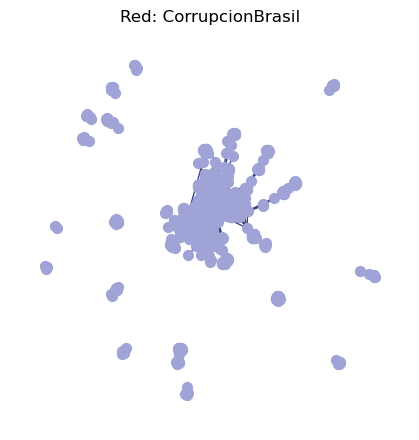

===== Métricas para la red: CorrupcionBrasil =====
Nodos totales: 804  |  Aristas totales: 7397
Componente gigante: 658 nodos, 6339 aristas

Clustering (global): 0.938
Clustering (giant): 0.931
Asortatividad (global): 0.835
Asortatividad (giant): 0.818
Densidad (global): 0.0229
Densidad (giant): 0.0293
Camino medio (giant): 4.93
Characteristic degree (exponential fit): 16.80



In [8]:
import networkx as nx
from graph_tool import Graph

def graph_tool_to_networkx(g):
    """
    Convert a graph_tool.Graph to a networkx.Graph.
    """
    nx_g = nx.Graph()
    for v in g.vertices():
        nx_g.add_node(int(v))
    for e in g.edges():
        nx_g.add_edge(int(e.source()), int(e.target()))
    return nx_g

# Convert the graph_tool.Graph to networkx.Graph
nx_final_network = graph_tool_to_networkx(final_network)

# Now call the mostrarRed function with the converted networkx.Graph
mostrarRed(nx_final_network, "CorrupcionBrasil")

# Calculate the metrics for the converted networkx.Graph
metricasArticulo(nx_final_network, "CorrupcionBrasil")

In [7]:
#Función de métricas "mejorada"

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import random

def mostrarRed(G, nombre):
    """
    Dibuja la red con layout spring.
    """
    plt.figure(figsize=(4, 4))
    pos = nx.spring_layout(G, seed=42)  # seed para fijar posición
    nx.draw(G, pos, node_size=50, node_color='#9FA3D5', edge_color='#3B4285', with_labels=False)
    plt.title(f'Red: {nombre}')
    plt.savefig(f'red_{nombre}.png', dpi=300, bbox_inches='tight')
    plt.show()


def obtenerComponenteGigante(G):
    """
    Retorna la subred que corresponde a la mayor componente conexa (giant component).
    """
    # Extrae todas las componentes conexas
    componentes = list(nx.connected_components(G))
    # Ordena por tamaño descendente y toma la primera
    comp_gigante = max(componentes, key=len)
    # Retorna la subred que corresponde a esa componente
    return G.subgraph(comp_gigante).copy()


def ajusteExponencialGrados(G):
    """
    Ajusta la distribución de grados a un modelo exponencial: p(k) ~ exp(-k/kappa).
    Devuelve la kappa (characteristic degree) estimada por regresión lineal en escala semi-log.
    
    Procedimiento:
      1. Se calcula el histograma de grados.
      2. Se omiten los valores k donde la probabilidad es 0.
      3. Se ajusta ln(prob(k)) = -k / kappa + C, vía regresión lineal.
      4. kappa = -1 / pendiente.
    """
    grados = list(dict(G.degree()).values())
    if len(grados) == 0:
        return None  # En caso de red vacía
    
    max_g = max(grados)
    if max_g == 0:
        return None  # Si todos los nodos tienen grado 0
    
    # Histograma de grados (densidad=True para obtener probabilidad)
    hist, bin_edges = np.histogram(grados, bins=range(max_g+2), density=True)
    
    # Los valores k posibles son bin_edges[i], pero hist[i] se asocia al intervalo [bin_edges[i], bin_edges[i+1])
    # Para grados enteros, tomamos k = 0,1,2,...,max_g
    ks = np.arange(len(hist))
    pk = hist
    
    # Filtrar donde pk > 0
    mask = pk > 0
    ks = ks[mask]
    pk = pk[mask]
    
    if len(ks) < 2:
        return None  # No se puede ajustar con un solo punto
    
    # Ajuste ln(pk) = -k/kappa + C
    ln_pk = np.log(pk)
    
    slope, intercept, r_value, p_value, std_err = linregress(ks, ln_pk)
    
    # slope ~ -1/kappa => kappa = -1/slope
    if slope == 0:
        return None
    kappa = -1.0 / slope
    
    return kappa


def metricasArticulo(G, nombre):
    """
    Calcula las métricas tal como en el artículo:
      - Clustering (red completa y componente gigante)
      - Asortatividad (red completa y componente gigante)
      - Densidad (red completa y componente gigante)
      - Longitud media de camino en el componente gigante
      - Ajuste exponencial de la distribución de grados (caracteristic degree) para la red completa.
    """
    # Componente gigante
    G_giant = obtenerComponenteGigante(G)
    
    # Clustering
    clustering_global = nx.average_clustering(G)
    clustering_giant = nx.average_clustering(G_giant)
    
    # Asortatividad (degree assortativity)
    assort_global = nx.degree_assortativity_coefficient(G)
    assort_giant = nx.degree_assortativity_coefficient(G_giant)
    
    # Densidad
    dens_global = nx.density(G)
    dens_giant = nx.density(G_giant)
    
    # Camino medio en el componente gigante
    # (si la componente gigante tiene un solo nodo o está vacía, average_shortest_path_length falla)
    avg_path_giant = None
    if G_giant.number_of_nodes() > 1:
        avg_path_giant = nx.average_shortest_path_length(G_giant)
    
    # Ajuste exponencial de la distribución de grados (red completa)
    kappa = ajusteExponencialGrados(G)
    
    print(f"===== Métricas para la red: {nombre} =====")
    print(f"Nodos totales: {G.number_of_nodes()}  |  Aristas totales: {G.number_of_edges()}")
    print(f"Componente gigante: {G_giant.number_of_nodes()} nodos, {G_giant.number_of_edges()} aristas\n")
    
    print(f"Clustering (global): {clustering_global:.3f}")
    print(f"Clustering (giant): {clustering_giant:.3f}")
    print(f"Asortatividad (global): {assort_global:.3f}")
    print(f"Asortatividad (giant): {assort_giant:.3f}")
    print(f"Densidad (global): {dens_global:.4f}")
    print(f"Densidad (giant): {dens_giant:.4f}")
    
    if avg_path_giant is not None:
        print(f"Camino medio (giant): {avg_path_giant:.2f}")
    else:
        print("Camino medio (giant): No definido (componentes muy pequeñas).")
    
    if kappa is not None:
        print(f"Characteristic degree (exponential fit): {kappa:.2f}")
    else:
        print("No se pudo ajustar la distribución de grados a un modelo exponencial.")
    print("========================================\n")


# ------------------ EJEMPLO DE USO ------------------
# Suponiendo que ya generaste tu red 'corruption_network_brazil' con el modelo:

# 1) Mostramos la red
mostrarRed(final_network, "CorrupcionBrasil")

# 2) Calculamos las métricas del artículo
metricasArticulo(final_network, "CorrupcionBrasil")


TypeError: 'Graph' object is not iterable

<Figure size 400x400 with 0 Axes>

In [14]:
#Se crea la función que calcula todas las métricas de la red

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scienceplots
from networkx.algorithms import community

#Funcion para graficar la red

def mostrarRed(G,nombre):
    
    plt.style.use('science')

    plt.figure(figsize=(4, 4))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, node_color='#9FA3D5', edge_color='#3B4285', with_labels=False)
    plt.title(f'Red: {nombre}')
    plt.savefig(f'red_{nombre}.png', dpi=300)
    plt.show()

#Funcion para graficar la distribución de grados

def distribucionDeGrado(G, nombre):
    # Obtener los grados de los nodos y calcular la distribución de frecuencia
    degrees = list(dict(nx.degree(G)).values())
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    probs = counts / len(G)

    # Eliminar grados con frecuencia cero
    non_zero_probs = probs[probs > 0]
    non_zero_degrees = unique_degrees[probs > 0]

    # Tomar el logaritmo de las probabilidades y los grados
    log_probs = np.log(non_zero_probs)
    log_degrees = np.log(non_zero_degrees)

    # Realizar un ajuste lineal
    slope, intercept, r_value, p_value, std_err = linregress(log_degrees, log_probs)

    # Calcular el exponente de la ley de potencias
    gamma = round(slope,2)
    
    # Crear el gráfico

    plt.style.use('science')

    # Graficar con escala logarítmica únicamente en el eje y (Distribución de grados en una red)
    plt.figure(figsize=(4, 4))

    plt.plot(non_zero_degrees, non_zero_probs, 'o-', color='#3B4285')
    plt.yscale('log')
    plt.xlabel('Grado')
    plt.ylabel('Probabilidad')
    plt.title('Distribución de grados')
    plt.legend()

    plt.savefig(f'distribucion_de_grados_{nombre}.png', dpi=300)
    plt.show()
    
    plt.figure(figsize=(4, 4)) 

    plt.loglog(unique_degrees, probs, 'o', color='#9FA3D5')
    plt.plot(unique_degrees, np.exp(intercept + slope * np.log(unique_degrees)), '--', label='Ajuste lineal', color='#3B4285')

    plt.xlabel('Grado (log)')
    plt.ylabel('Probabilidad (log)')
    plt.legend()
    plt.title('Distribución de grados (escala logarítmica)')

    # Guardar el gráfico con mayor resolución
    plt.savefig(f'distribucion_de_grados_log_{nombre}.png', dpi=300)
    plt.show()
    
    # Imprimir el exponente
    print("Exponente de la ley de potencias (gamma):", gamma)    

#Función para calcular la estructura en comunidades

def estructuraComunidades(G, nombre):
    # Detectar comunidades usando el algoritmo de detección de comunidades de Louvain
    comunidades = community.louvain_communities(G)

    # Número de comunidades
    num_comunidades = len(comunidades)
    
    #Cantidad de nodos en cada comunidad
    nodos_comunidad = [len(comunidad) for comunidad in comunidades]
    
    # Promedio de nodos por comunidad
    promedio_nodos = round(np.mean(nodos_comunidad),2)

    # Crear un diccionario de colores para las comunidades
    color_map = {}
    for i, comunidad in enumerate(comunidades):
        for node in comunidad:
            color_map[node] = i
            
    # Crear el gráfico de la red con colores para las comunidades
    plt.figure(figsize=(4, 4)) # Tamaño del gráfico
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, node_color=list(color_map.values()), edge_color='gray', with_labels=False, cmap=plt.cm.tab20)
    plt.title(f'Red: {nombre} (Comunidades)')
    plt.savefig(f'comunidades_{nombre}.png', dpi=300)
    plt.show()
    
    # Imprimir el número de comunidades y el tamaño de cada una
    print(f"Número de comunidades: {num_comunidades}")
    print(f"Número de nodos por comunidad: {nodos_comunidad}")
    print(f"Promedio de nodos por comunidad: {promedio_nodos}")

    # Encontrar la comunidad más grande
    max_comunidad = max(nodos_comunidad)

    print(f"Comunidad más grande: {max_comunidad} nodos")
    
    #Etiquetar los nodos de la comunidad más grande
    nodos_max_comunidad = [node for node in G.nodes() if node in comunidades[np.argmax(nodos_comunidad)]]
    
    #Seleccionar la red de la comunidad más grande
    G_max_comunidad = G.subgraph(nodos_max_comunidad)
    return G_max_comunidad

         
# Propiedad de mundo pequeño

def mundoPequeno(G, G_max_comunidad, nombre):
    
    # Calcular el coeficiente de agrupamiento global
    clustering_coeff = round(nx.average_clustering(G),2)

    # Calcular el coeficiente de agrupamiento local (comunidad más grande)
    clustering_coeff_local = round(nx.average_clustering(G_max_comunidad),2)
    
    # Calcular el camino medio más corto de la red local
    try:
        average_path_length = round(nx.average_shortest_path_length(G_max_comunidad),2)
    except nx.NetworkXError:
        average_path_length = round(float('inf'),2)

    print(f"Coeficiente de agrupamiento global: {clustering_coeff}")
    print(f"Coeficiente de agrupamiento local: {clustering_coeff_local}")
    print(f"Camino medio más corto: {average_path_length}")
    
    if  (clustering_coeff_local > .90 and average_path_length < 5):
        print(f"La red '{nombre}' tiene la propiedad de mundo pequeño.")
    else:
        print(f"La red '{nombre}' no tiene la propiedad de mundo pequeño.")
    
#Asortaividad

def asortatividad(G, G_max_comunidad):
    # Calcular el coeficiente de asortatividad de grado global
    assortativity_coeff = round(nx.degree_assortativity_coefficient(G),2)
    # Calcular el coeficiente de asortatividad de grado local
    assortativity_coeff_local = round(nx.degree_assortativity_coefficient(G_max_comunidad),2)
    # Imprimir los coeficientes de asortatividad
    print(f"Coeficiente de Asortatividad Global: {assortativity_coeff}")
    print(f"Coeficiente de Asortatividad Local: {assortativity_coeff_local}")
 
def densidad(G, G_max_comunidad):
    # Calcular la densidad de la red global
    density = round(nx.density(G), 2)
    # Calcular la densidad de la red local
    density_local = round(nx.density(G_max_comunidad), 2)
    # Imprimir la densidad
    print(f"Densidad de la red global: {density}")
    print(f"Densidad de la red: {density_local}")
    
#Función global que calcula todas las métricas
            
def metricasRed(G, nombre):
    # Mostrar la red
    mostrarRed(G, nombre)
    # Obtener los grados de los nodos y calcular la distribución de frecuencia
    distribucionDeGrado(G, nombre)
    # Estructura en comunidades
    G_max_comunidad = estructuraComunidades(G, nombre)
    # Propiedad de mundo pequeño
    mundoPequeno(G, G_max_comunidad, nombre)
    # Asortatividad
    asortatividad(G, G_max_comunidad)
    # Densidad
    densidad(G, G_max_comunidad)

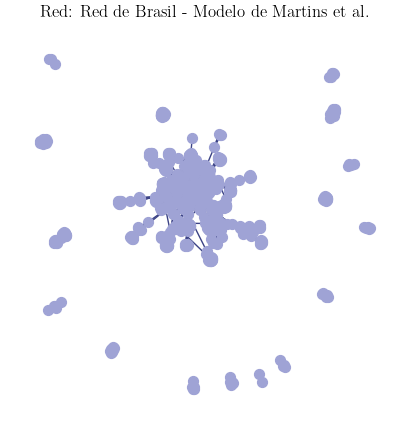

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


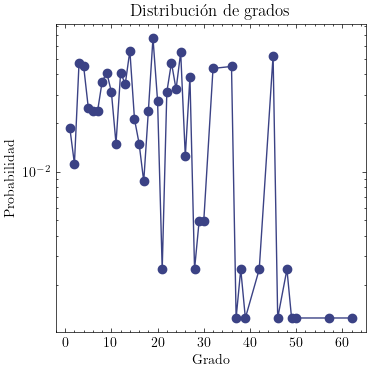

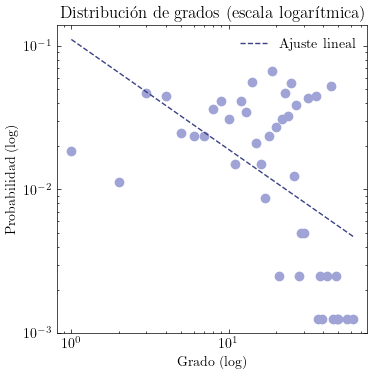

Exponente de la ley de potencias (gamma): -0.77


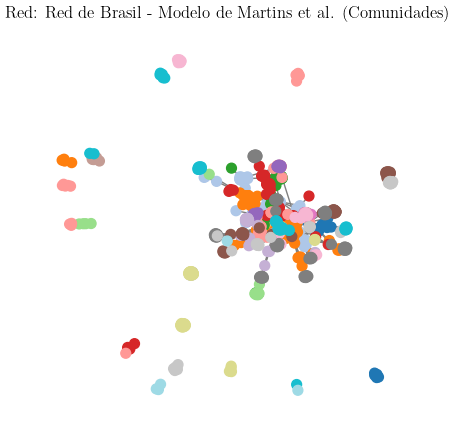

Número de comunidades: 35
Número de nodos por comunidad: [5, 15, 43, 36, 26, 63, 4, 4, 40, 7, 5, 49, 48, 5, 5, 26, 31, 39, 28, 18, 8, 5, 12, 23, 43, 47, 7, 33, 4, 20, 43, 52, 5, 2, 3]
Promedio de nodos por comunidad: 22.97
Comunidad más grande: 63 nodos
Coeficiente de agrupamiento global: 0.94
Coeficiente de agrupamiento local: 0.85
Camino medio más corto: 2.46
La red 'Red de Brasil - Modelo de Martins et al.' no tiene la propiedad de mundo pequeño.
Coeficiente de Asortatividad Global: 0.83
Coeficiente de Asortatividad Local: 0.23
Densidad de la red global: 0.02
Densidad de la red: 0.2


In [18]:
#Calcular las métricas de la red de corrupción de Brasil
nombre = 'Red de Brasil - Modelo de Martins et al.'
metricasRed(nx_final_network, nombre)